In [40]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import string
import pickle
import json
%matplotlib inline



# Data Processing


In [41]:
num_of_data_point_i_want = 100000
data = pd.read_csv('train.csv',nrows=num_of_data_point_i_want, header=None)
#in total : 1710670 data point
res = data[8]
del res[0]


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,2,3,4,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
##get the float version of each trajectory
#initialize
trajectory = []
temp = []
final_res = []
test_res = []

for i in range(len(res)):
    #get the str version of each trajectory
    trajectory.append(res[i+1].split(',')) 
    
    
for i in range(len(trajectory)):
        # if the length of a trajectory is shorter than 1, means the trajectory doesn't exist
        if len(trajectory[i]) > 1 :
            for j in range(len(trajectory[i])):
                #remove unnecessary element 
                temp1 = trajectory[i][j].replace(']','')
                temp2 = temp1.replace('[','')
                trajectory[i][j] = float(temp2)

#delete all empty element
unwanted = []
for i in range(len(trajectory)):
    if trajectory[i] == ['[]']:
        unwanted.append(i)
trajectory = [j for i,j in enumerate(trajectory) if i not in unwanted]

longitude = [1]*(len(trajectory))
latitude = [1]*(len(trajectory))

#longitude and latitude for graph
for i in range(len(trajectory)):
    longitude[i] = trajectory[i][::2]
    latitude[i] = trajectory[i][1::2]

### Limit the data to bounded area

In [43]:
################
##有一位老人在porto画了一个圈
#change the variable bound_left,bound_right,bound_up,bound_down to limit the trajectories
#in latitude
bound_left = -8.692
bound_right = -8.535
#in longitude
bound_up = 41.2457
bound_down = 41.065

unwanted = []
#in fianl_res, each row means one trajectory
for i in range(len(trajectory)):
    for j in range(len(longitude[i])):
        ##if its not in the range
        
        if (longitude[i][j]>bound_right) or (longitude[i][j]<bound_left):
            unwanted.append(i)
            break
        elif (latitude[i][j]>bound_up) or (latitude[i][j]<bound_down):
            unwanted.append(i)
            break

#delete unwanted element from the list to get bounded longnitude and latitude
longitude_bound = [j for i,j in enumerate(longitude) if i not in unwanted]
latitude_bound = [j for i,j in enumerate(latitude) if i not in unwanted]

## AND refresh the final_res list to be:
final_res_new = [j for i,j in enumerate(trajectory) if i not in unwanted]
# len(longitude_bound)
# len(latitude_bound)


### visualizing

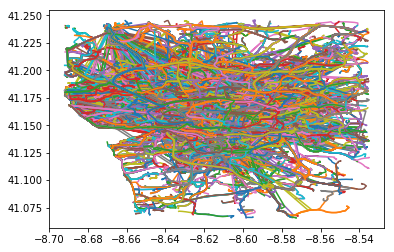

In [44]:
#######
#visualizing 
for i in range(len(final_res_new)-1):
    xlabel = longitude_bound[i]
    ylabel = latitude_bound[i]
    plt.plot(xlabel,ylabel)
plt.show() 


### Set grid

In [45]:
## modify num_grid_row and num_grid_col to change the grid numbers
num_grid_row = 20
num_grid_col = 20

#get the length of each grid
len_grid_row = (bound_right - bound_left)/num_grid_row
len_grid_col = (bound_up - bound_down)/num_grid_col

#change every geographic point into a specific grid number
row_index = []
col_index = []
row_index_temp1 = []
col_index_temp1 = []
for i in range(len(final_res_new)):
    
    for j in range(len(latitude_bound[i])):
        row_index_temp = int((longitude_bound[i][j] - bound_left)//len_grid_row)
        col_index_temp = int((latitude_bound[i][j] - bound_down)//len_grid_col)
        row_index_temp1.append(row_index_temp)
        col_index_temp1.append(col_index_temp)
    row_index.append(row_index_temp1)
    col_index.append(col_index_temp1)
    row_index_temp1 = []
    col_index_temp1 = []
        

In [46]:
###find the length of the trajectories
len_size = 80
index_len = np.zeros(len_size)
temp = 0 
for i in range(len(row_index)):
    if  (len(row_index[i])<len_size):
        index_len[len(row_index[i])]+=1
        temp += 1
for i in range(80):
    index_len[i] = index_len[i]/temp

#index_len

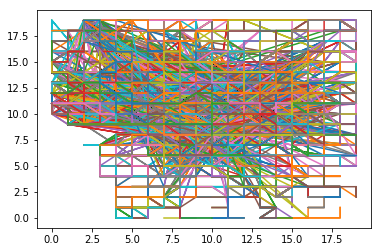

In [47]:
for i in range(len(final_res_new)-1):
    xlable = row_index[i]
    ylable = col_index[i]
    plt.plot(xlable,ylable)
plt.show() 

# Predictors

### 1. P(E|S)

In [48]:
###get the start and end point for each trajectory

#initialize
start_row = []
start_col = []
end_row = []
end_col = []
#find start and end point
for i in range(len(row_index)):
    start_row.append(row_index[i][0])
    start_col.append(col_index[i][0])
    end_row.append(row_index[i][-1])
    end_col.append(col_index[i][-1])
    

In [49]:
#输入一个start_point, 输出一个 dictionary，这个dictionary 的每一个key是possible end_point 然后对应的概率

def PES(start_point_row,start_point_col):
    dic = {}
    for i in range(len(start_row)):
        #如果对应的end point 已经存在，那么dict[this spcific start_point] += 1;
        #如果对应的end point 还没有记录过，那么dict[this specific start_point] = 1;
            
        if (start_row[i] == start_point_row) and (start_col[i] == start_point_col):
            end = (end_row[i],end_row[i])
            if end in dic:
                dic[end] += 1
            else:
                dic[end] = 1
##transfer count into probability
    total = 0
    for k in dic:
        total += dic[k]
    for k in dic:
        dic[k] = dic[k]/total    
    return dic

#####
##THIS code may be extremely slow and need modify


### 2. P(E|C)

In [50]:
def PEC(start_point_row,start_point_col):
    dic = {}
    #for every trajectory
    for i in range(len(row_index)):
        #for every point in the trajectory
        for j in range(len(row_index[i])-1):
            if(row_index[i][j] == start_point_row) and (col_index[i][j] == start_point_col):
                end = (row_index[i][len(row_index[i])-1], col_index[i][len(col_index[i])-1])
                if end in dic:
                    dic[end] += 1
                else: 
                    dic[end] = 1
    total = 0
    for k in dic:
        total+=dic[k]
    for k in dic:
        dic[k] = dic[k]/total
    return dic

### 3. First_order Markov Chain

In [51]:
#create an arrary with trajectories end in 'TRUE'
from copy import copy, deepcopy
row_with_finish = deepcopy(row_index)
col_with_finish = deepcopy(col_index)
for i in range(len(longitude_bound)):
    row_with_finish[i].append('TRUE')
    col_with_finish[i].append('TRUE')

#找附近的点，顺序是：0:self 1:top 2:bottom 3:left 4:right 5:top-left 6:top-right 
#7:bot-left 8:bot-right 9:finish
def adjacent_point(start_point_row,start_point_col,direction):
    if (direction == 0):
        next_state = (start_point_row,start_point_col)
    elif (direction == 1):
        next_state = (start_point_row+1,start_point_col)
    elif (direction == 2):
        next_state = (start_point_row-1,start_point_col)
    elif (direction == 3):
        next_state = (start_point_row,start_point_col-1)
    elif (direction == 4):
        next_state = (start_point_row,start_point_col+1)
    elif (direction == 5):
        next_state = (start_point_row+1,start_point_col-1)
    elif (direction == 6):
        next_state = (start_point_row+1,start_point_col+1)
    elif (direction == 7):
        next_state = (start_point_row-1,start_point_col-1)
    elif (direction == 8):
        next_state = (start_point_row-1,start_point_col+1)
    else:
        next_state = ('TRUE','TRUE')
    return next_state
    
##create a dictionary which contains the probability of next state: 
#the next state can be the same, the finish, or the adjacent
epsilon = 0.1

def first_markov(start_point_row,start_point_col):
    dic = {}
    # for every trajectory    
    for i in range(len(row_with_finish)):
        #for every point during the trip
        for j in range(len(row_with_finish[i])-1):
            if (row_with_finish[i][j]==start_point_row) and (col_with_finish[i][j]==start_point_col):
                next_state = (row_with_finish[i][j+1],col_with_finish[i][j+1])
                if next_state in dic:
                    dic[next_state] += 1
                else:
                    dic[next_state] = 1
    #####add epsilon to every adjcent point to avoid 0 probability
    

    for i in range(9):
        next_state = adjacent_point(start_point_row,start_point_col,i)
        #print(next_state)
        a = next_state[0]
        #print('a = ',a)
        b = next_state[1]
        #print('b = ',b)

        #print('num_grid_col = ',num_grid_col )
        #print(a<=num_grid_col)
        
        
        if(a>=0) and (a<num_grid_col) and (b>=0) and (b<num_grid_row):
            if next_state in dic:
                
                dic[next_state] += epsilon
            else:
                dic[next_state] = epsilon
    
    ##transfer count into probability
    total = 0
    for k in dic:
        total += dic[k]
    for k in dic:
        dic[k] = dic[k]/total
    
    return dic
#print(bool(first_markov(0,0)))
#print(first_markov(1,10))
#for j in first_markov(1,10):
#    print(j[1]*10)

In [52]:
T = np.zeros((401,401))
#先不管finish->finish的那一个row
for i in range(400):
    n = i//num_grid_col
    m = i%num_grid_row
    
    if(n<20 and m<20):
        dic = first_markov(n,m)
        for j in dic:
            if(j!=('TRUE','TRUE')):
                col_n =  j[0]*num_grid_col+j[1]
                T[i][col_n] = dic[j]
            else:
                T[i][400] = dic[j]
                
#然后set finish那一个row
T[400][400] = 1

In [53]:

from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from numpy.linalg import solve, norm
from numpy.random import rand
A = lil_matrix((1000, 1000))


In [54]:
#sum over T^2^0 T^2^1 to T^2^5
T_sum = []
T_sum.append(T)
square_times =5
for i in range(square_times):
    T = np.matmul(T,T)
    #row_sums = T.sum(axis=1)
    #row_sums[row_sums == 0] = 1
    #T = T / row_sums[:, np.newaxis]
    T_sum.append(T)
    


In [55]:
#index_len
index_len_new = np.zeros(7)
index_len_new[0] = index_len[1]
index_len_new[1] = index_len[2]+index_len[3]
index_len_new[2] = sum(index_len[4:8])
index_len_new[3] = sum(index_len[8:16])
index_len_new[4] = sum(index_len[16:32])
index_len_new[5] = sum(index_len[32:64])
index_len_new[6] = sum(index_len[64:])

In [56]:
index_len_new

array([ 0.01311334,  0.00678394,  0.00827254,  0.04158996,  0.29045931,
        0.54118088,  0.09860003])

In [57]:
res = np.zeros(401)
T_temp = np.zeros((401,401))
for i in range(square_times+1):
    T_temp+=index_len_new[i]*T_sum[i]

    
T_401_400 = np.transpose(T_temp)

initial_state = 100
temp = [0 for x in range(401)]
temp[initial_state] = 1
res = np.dot(T_401_400,temp)

total = 0
for i in range(len(res)):
    if(res[i]!=0):
        print('at row ',i,' the probability is ',res[i])
        total += res[i]
total

at row  0  the probability is  6.16147559079e-05
at row  1  the probability is  8.48781537711e-05
at row  2  the probability is  6.88685456115e-05
at row  3  the probability is  4.96905951233e-05
at row  4  the probability is  3.2233059374e-05
at row  5  the probability is  1.90021770978e-05
at row  6  the probability is  1.02824159185e-05
at row  7  the probability is  5.06017428176e-06
at row  8  the probability is  2.1428753868e-06
at row  9  the probability is  6.93937865804e-07
at row  10  the probability is  4.45158987396e-07
at row  11  the probability is  3.9435531986e-07
at row  12  the probability is  8.84354662843e-08
at row  13  the probability is  3.17229167834e-10
at row  14  the probability is  4.37057369043e-10
at row  15  the probability is  8.19478555195e-10
at row  16  the probability is  1.10427820826e-10
at row  17  the probability is  7.48756515448e-11
at row  18  the probability is  6.05011466949e-12
at row  19  the probability is  6.50272486608e-12
at row  20  t

0.90139996818254253

# Evaluation

### load test data

In [58]:
data_test = pd.read_csv('test.csv', header=None)
res_test = data_test[8]
del res_test[0]

In [59]:
#change to list
trajectory1 = res_test[1].split(',')
trajectory1_test=[]
for i in range(len(trajectory1)):
    temp1 = trajectory1[i].replace(']','')
    temp2 = temp1.replace('[','')
    trajectory1_test.append(float(temp2))  

    
##get the float version of each trajectory
trajectory_test = []
for i in range(len(res_test)):
    trajectory_test.append(res_test[i+1].split(',')) 
    
for i in range(len(trajectory_test)):
        for j in range(len(trajectory_test[i])):
            temp1 = trajectory_test[i][j].replace(']','')
            temp2 = temp1.replace('[','')

            trajectory_test[i][j] = float(temp2)

#get longitude and latitude
longitude_test = [1]*(len(trajectory_test))
latitude_test = [1]*(len(trajectory_test))
for i in range(len(trajectory_test)):
    longitude_test[i] = trajectory_test[i][::2]
    latitude_test[i] = trajectory_test[i][1::2]

###有一位老人在porto画了一个圈
unwanted = []
for i in range(len(trajectory_test)):
    for j in range(len(longitude_test[i])):
        ##if its not in the range
        if (longitude_test[i][j]>bound_right) or (longitude_test[i][j]<bound_left):
            unwanted.append(i)
            break
        elif (latitude_test[i][j]>bound_up) or (latitude_test[i][j]<bound_down):
            unwanted.append(i)
            break

longitude_bound_test = [j for i,j in enumerate(longitude_test) if i not in unwanted]
latitude_bound_test = [j for i,j in enumerate(latitude_test) if i not in unwanted]
trajectory_new_test = [j for i,j in enumerate(trajectory_test) if i not in unwanted]

#######GRID
row_index_test = []
col_index_test = []
row_index_temp1 = []
col_index_temp1 = []
for i in range(len(trajectory_new_test)):
    for j in range(len(latitude_bound_test[i])):
        row_index_temp = int((longitude_bound_test[i][j] - bound_left)//len_grid_row)
        col_index_temp = int((latitude_bound_test[i][j] - bound_down)//len_grid_col)
        row_index_temp1.append(row_index_temp)
        col_index_temp1.append(col_index_temp)
    row_index_test.append(row_index_temp1)
    col_index_test.append(col_index_temp1)
    row_index_temp1 = []
    col_index_temp1 = []


In [60]:
######################################
test_data_row = row_index_test
test_data_col = col_index_test 

## evaluation method 1: accurarcy 

In [ ]:
Data Size = 100000
P(E|S)      = 0.016
P(E|C)      = 0.141
First_Order = 0.0064(T^64)
First_Order_update = 0.183

### 1. for P(E|S)

In [61]:

success_num = 0
for i in range(len(test_data_row)):
    #get the dictionary containing the probability distribution given the start point
    predicted_1 = PES(test_data_row[i][0],test_data_col[i][0])
    #find the maximum probability, if it mathes the test_data, then (success_num += 1)
    max_index = (test_data_row[i][0],test_data_col[i][0])
    max_value = 0
    for k in predicted_1:
        if max_value<predicted_1[k] and (k!= 0):
            max_value = predicted_1[k]
            max_index = k
    if(max_index == ('TRUE','TRUE')):
        max_index = (test_data_row[i][0],test_data_col[i][0])

    predicted_row_1 = max_index[0]
    predicted_col_1 = max_index[1]
    if(predicted_row_1==test_data_row[i][-1]) and (predicted_col_1 == test_data_col[i][-1]):
        success_num += 1

success_rate_PES = success_num/len(test_data_row)
        
success_rate_PES

0.01607717041800643

### 2. for P(E|C)

In [62]:

success_num = 0
for i in range(len(test_data_row)):
    #get the dictionary containing the probability distribution given the start point
    predicted_1 = PEC(test_data_row[i][0],test_data_col[i][0])
    #find the maximum probability, if it mathes the test_data, then (success_num += 1)
    max_index = 0
    max_value = 0
    for k in predicted_1:
        if (max_value<predicted_1[k]):
            max_value = predicted_1[k]
            max_index = k
    if(max_index == ('TRUE','TRUE')):
        max_index = (test_data_row[i][0],test_data_col[i][0])
        
    predicted_row_1 = max_index[0]
    predicted_col_1 = max_index[1]
    if(predicted_row_1==test_data_row[i][-1]) and (predicted_col_1 == test_data_col[i][-1]):
        success_num += 1

success_rate_PEC = success_num/len(test_data_row)
print(success_num)
print(success_rate_PEC)

44
0.1414790996784566


### 3. for first_markov model

In [63]:
##evaluation method 1: accurarcy 
#for first_markov model
success_num = 0

max_index = 0
max_value = 0
        
###
for i in range(len(test_data_row)):
    initial_state = (test_data_row[i][0] * num_grid_row) + test_data_col[i][0]
    temp = [0 for x in range(401)]
    temp[initial_state] = 1
    res = np.dot(T_401_400,temp)
    
    total = 0
    for j in range(len(res)):
        if (max_value < res[j]):
            max_value = res[j]
            max_index = j

    if(max_index == 400):
        max_index = (test_data_row[i][0],test_data_col[i][0])
    else:
        if(type(max_index) == int):
            max_index = (max_index//20,max_index%20)
    
    if(max_index[0] == test_data_row[i][-1]) and (max_index[1] == test_data_col[i][-1]):
        success_num += 1
success_rate_first_markov =  success_num/len(test_data_row)
print(success_num)
print(success_rate_first_markov)

2
0.006430868167202572


### 4. T * Current State

In [64]:
success_num = 0

max_index = 0
max_value = 0
        
###
for i in range(len(test_data_row)):
    for j in range(len(test_data_row[i])):
        current_state = (test_data_row[i][j]*num_grid_row+test_data_col[i][j])
        temp = np.zeros(401)
        temp[current_state] = 1
        res = np.dot(T_401_400,temp)
        
        total = 0
        for x in range(len(res)):
            if(max_value<res[x]):
                max_value = res[x]
                max_index = x
        if(max_index == 400):
            max_index =  (test_data_row[i][j],test_data_col[i][j])
        else:
            if(type(max_index) == int):
                max_index = (max_index//20, max_index%20)
            
            if(max_index[0] == test_data_row[i][-1]) and (max_index[1] == test_data_col[i][-1]):
                success_num += 1
success_rate_first_markov =  success_num/len(test_data_row)
print(success_num)
print(success_rate_first_markov)

57
0.1832797427652733


# Evaluation method 2: hit rate at k

In [65]:
k = 10

### 1. for P(E|S)

In [66]:
##compute the precision at k

total_precision = 0

for i in range(len(test_data_row)):
    prediction = PES(test_data_row[i][0],test_data_col[i][0]) #returns the dictionary contains probability dist.

    
    # get the sorted list of the keys based on the values of the dictionary
    prediction_sorted = sorted(prediction,key = prediction.get)
    #print('The prediction is ',prediction_sorted[-2])
    true_label = (test_data_row[i][-1],test_data_col[i][-1])

    #print('The target is ', true_label, '\n')
    
    temp = 0
    precision_at_k = 0
    for i in range(k):
        if(len(prediction_sorted)>k):
            if(true_label == prediction_sorted[-1-i]):
                temp+=1
    precision_at_k += temp/k
    #print(precision_at_k)
    total_precision += precision_at_k

print('The total Precision-at-k with k = ',k,' is ',total_precision)    
print('The average of total Precision-at-k with k = ',k,' is ',total_precision/len(test_data_row)) 
        

The total Precision-at-k with k =  10  is  1.6000000000000003
The average of total Precision-at-k with k =  10  is  0.005144694533762059


In [67]:
##compute the average precision at k

total_precision = 0
avg_precision_at_k = 0
total_avg_precision_at_k = 0

for i in range(len(test_data_row)):
    #get the prediction and  label
    prediction = PES(test_data_row[i][0],test_data_col[i][0]) 
    prediction_sorted = sorted(prediction,key = prediction.get)
    true_label = (test_data_row[i][-1],test_data_col[i][-1]) 
    
    #initialize
    temp = 0
    #loop through the top k rank of the prediction
    for n in range(k):
        if(len(prediction_sorted)>k):
            if(true_label == prediction_sorted[-1-n]):
                temp += 1/(n+1)
    avg_precision_at_k = temp/k
    #print(avg_precision_at_k)
    total_avg_precision_at_k += avg_precision_at_k

print('The total avg_Precision-at-k with k = ',k,' is ',total_avg_precision_at_k)    
print('The average of total avg_Precision-at-k with k = ',k,' is ',total_avg_precision_at_k/len(test_data_row)) 


The total avg_Precision-at-k with k =  10  is  0.9783333333333335
The average of total avg_Precision-at-k with k =  10  is  0.003145766345123259


### 2. For P(E|C)

In [68]:
##compute the precision at k

total_precision = 0

for i in range(len(test_data_row)):
    prediction = PEC(test_data_row[i][0],test_data_col[i][0])
    prediction_sorted = sorted(prediction,key = prediction.get)
    true_label = (test_data_row[i][-1],test_data_col[i][-1])
    temp = 0
    precision_at_k = 0
    for i in range(k):
        if(len(prediction_sorted)>k):
            if(true_label == prediction_sorted[-1-i]):
                temp+=1
    precision_at_k += temp/k
    total_precision += precision_at_k

print('The total Precision-at-k with k = ',k,' is ',total_precision)    
print('The average of total Precision-at-k with k = ',k,' is ',total_precision/len(test_data_row)) 
        

The total Precision-at-k with k =  10  is  15.499999999999961
The average of total Precision-at-k with k =  10  is  0.04983922829581981


In [69]:
##compute the average precision at k

total_precision = 0
avg_precision_at_k = 0
total_avg_precision_at_k = 0
for i in range(len(test_data_row)):
    #get the prediction and  label
    prediction = PEC(test_data_row[i][0],test_data_col[i][0]) 
    prediction_sorted = sorted(prediction,key = prediction.get)
    true_label = (test_data_row[i][-1],test_data_col[i][-1])  
    #initialize
    temp = 0
    #loop through the top k rank of the prediction
    for n in range(k):
        if(len(prediction_sorted)>k):
            if(true_label == prediction_sorted[-1-n]):
                temp += 1/(n+1)
    avg_precision_at_k = temp/k
    #print(avg_precision_at_k)
    total_avg_precision_at_k += avg_precision_at_k

print('The total avg_Precision-at-k with k = ',k,' is ',total_avg_precision_at_k)    
print('The average of total avg_Precision-at-k with k = ',k,' is ',total_avg_precision_at_k/len(test_data_row)) 

The total avg_Precision-at-k with k =  10  is  7.217698412698401
The average of total avg_Precision-at-k with k =  10  is  0.02320803348134534


### 3. for First_order Markov Model

In [70]:
##compute the precision at k

total_precision = 0

for i in range(len(test_data_row)):
    
    initial_state = (test_data_row[i][0] * num_grid_row) + test_data_col[i][0]
    temp = [0 for x in range(401)]
    temp[initial_state] = 1
    
    res = np.dot(T_401_400,temp)
    res[initial_state] += res[400]
    res = res[:-1]
    prediction_sorted = [i[0] for i in sorted(enumerate(res), key=lambda x:x[1])]
    
    true_label = test_data_row[i][-1]*20+test_data_col[i][-1]

    #if(max_index == 401):
        #max_index = (test_data_row[i][0],test_data_col[i][0])
    temp = 0
    precision_at_k = 0
    for i in range(k):
        if(len(prediction_sorted)>5):
            if(true_label == prediction_sorted[-1-i]):
                temp+=1
    precision_at_k += temp/5
    
    total_precision += precision_at_k

print('The total Precision-at-k with k = ',k,' is ',total_precision)   
print('The average of total Precision-at-k with k = ',k,' is ',total_precision/len(test_data_row)) 

The total Precision-at-k with k =  10  is  33.59999999999994
The average of total Precision-at-k with k =  10  is  0.10803858520900302


In [71]:
##compute the average precision at k
total_precision = 0
avg_precision_at_k = 0
total_avg_precision_at_k = 0

for i in range(len(test_data_row)):
    initial_state = (test_data_row[i][0] * num_grid_row) + test_data_col[i][0]
    temp = [0 for x in range(401)]
    temp[initial_state] = 1
    res = np.dot(T_401_400,temp)
    res[initial_state] += res[400]
    res = res[:-1]
    prediction_sorted = [i[0] for i in sorted(enumerate(res), key=lambda x:x[1])]
    
    true_label = test_data_row[i][-1]*20+test_data_col[i][-1]
    temp = 0
    #loop through the top k rank of the prediction
    for n in range(k):
        if(len(prediction_sorted)>k):
            if(true_label == prediction_sorted[-1-n]):
                temp += 1/(n+1)
    avg_precision_at_k = temp/k
    #print(avg_precision_at_k)
    total_avg_precision_at_k += avg_precision_at_k

print('The total avg_Precision-at-k with k = ',k,' is ',total_avg_precision_at_k)    
print('The average of total avg_Precision-at-k with k = ',k,' is ',total_avg_precision_at_k/len(test_data_row)) 

The total avg_Precision-at-k with k =  10  is  7.803373015873002
The average of total avg_Precision-at-k with k =  10  is  0.02509123156229261


# Evaluation method 3: Log likelihood estimator

In [72]:
from sklearn.metrics import log_loss

### 1. for P(E|S)

In [73]:
y_true = [0]*400
y_pred = [0]*400
for i in range(400):
    y_pred[i] = [1,0]
total = 0
for i in range(len(test_data_row)):
    #true
    true_label = test_data_row[i][-1]*20+test_data_col[i][-1]
    y_true[true_label] = 1
    #predict
    predict = PES(test_data_row[i][0],test_data_col[i][0])
    for k in predict:
        pred_label = k[0]*20+k[1]
        y_pred[pred_label] = [1-predict[k],predict[k]]
    total += log_loss(y_true, y_pred)
    y_true = [0]*400
    for i in range(400):
        y_pred[i] = [1,0]
print('The sum of log_loss for P(E|S) alogrithm is ',total)

The sum of log_loss for P(E|S) alogrithm is  26.3662566896


### 2. for P(E|C)

In [74]:
y_true = [0]*400
y_pred = [0]*400
for i in range(400):
    y_pred[i] = [1,0]
total = 0
for i in range(len(test_data_row)):
    #true
    true_label = test_data_row[i][-1]*20+test_data_col[i][-1]
    y_true[true_label] = 1
    #predict
    predict = PEC(test_data_row[i][0],test_data_col[i][0])
    for k in predict:
        pred_label = k[0]*20+k[1]
        y_pred[pred_label] = [1-predict[k],predict[k]]
    total += log_loss(y_true, y_pred)
    y_true = [0]*400
    for i in range(400):
        y_pred[i] = [1,0]
print('The sum of log_loss for P(E|C) alogrithm is ',total)

The sum of log_loss for P(E|C) alogrithm is  4.41121358676


### 3. First_order markov model

In [75]:
y_true = [0]*400
y_pred = [0]*400
for i in range(400):
    y_pred[i] = [1,0]
total = 0
for i in range(len(test_data_row)):
    #true
    true_label = test_data_row[i][-1]*20+test_data_col[i][-1]
    y_true[true_label] = 1
    #predict
    initial_state = (test_data_row[i][0] * num_grid_row) + test_data_col[i][0]
    temp = [0 for x in range(401)]
    temp[initial_state] = 1
    res = np.dot(T_401_400,temp)
    for j in range(len(res)-1):
        if (j == true_label):
            temp = res[j]+res[400]
            y_pred[j] = [1-temp,temp]
        else:
            y_pred[j] = [1-res[j],res[j]]
            
    total += log_loss(y_true, y_pred)
    
    y_true = [0]*400
    for i in range(400):
        y_pred[i] = [1,0]
    
    
print('The sum of log_loss for first-order markov model alogrithm is ',total)

The sum of log_loss for first-order markov model alogrithm is  1.10895507254
